In [1]:
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Coin flip

Bayes Theorem:

$H$ = hypothesis
$D$ = data

$ p(H|D) = \frac{p(D|H)p(H)}{p(D)} $

where:

* $ p(H)$: Prior - What we knew previously

* $ p(D|H)$: Likelihood - How we introduce the data; Expression of plausibility of data give hypothesis

* $ p(H|D)$: Posterior - Our result

* $ p(D)$: Evidence - marginal likelihood. 

### Likelihood Function

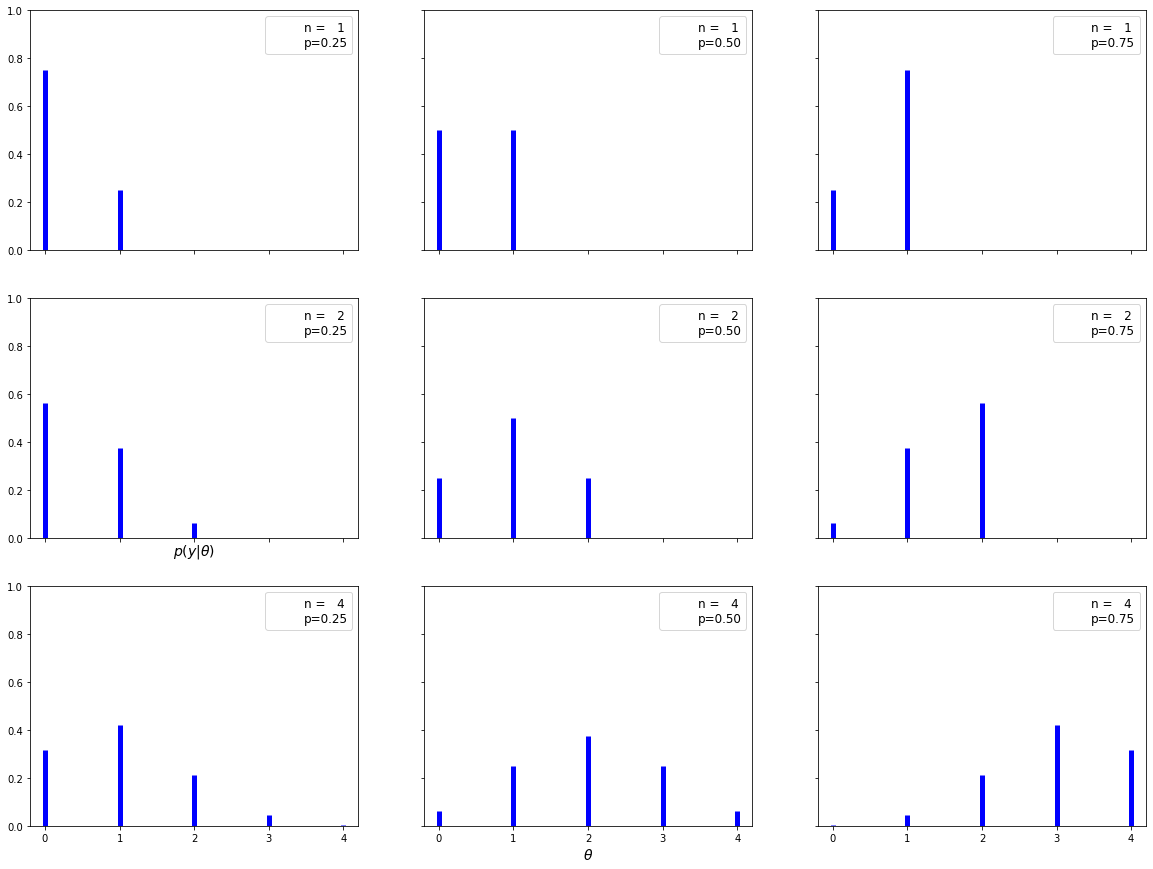

In [10]:
# Number of flips
n_params = [1,2,4]

#Probability of success
p_params = [0.25, 0.5, 0.75]

x = np.arange(0, max(n_params)+1)
f, ax = plt.subplots(len(n_params), len(p_params), sharex=True, sharey= True,figsize=(20, 15))

for i in range(len(n_params)):
    for j in range(len(p_params)):
        n = n_params[i]
        p = p_params[j]
        y = stats.binom(n=n, p=p).pmf(x)
        ax[i,j].vlines(x, 0, y, colors = 'b', lw= 5)
        ax[i,j].set_ylim(0,1)
        ax[i,j].plot(0,0, label = f"n = {n:3.2g}\np={p:3.2f}", alpha = 0)
        ax[i,j].legend(fontsize=12)
        
ax[2,1].set_xlabel("$\\theta$", fontsize=14)
ax[1,0].set_xlabel("$p(y|\\theta)$", fontsize=14)
ax[0,0].set_xticks(x)

## Choose Prior

Beta Function

$ p(\theta) = \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha) \Gamma(\beta)}\theta^{\alpha-1}(1-\theta)^{\beta-1} $

Text(0, 0.5, '$p(\\theta)$')

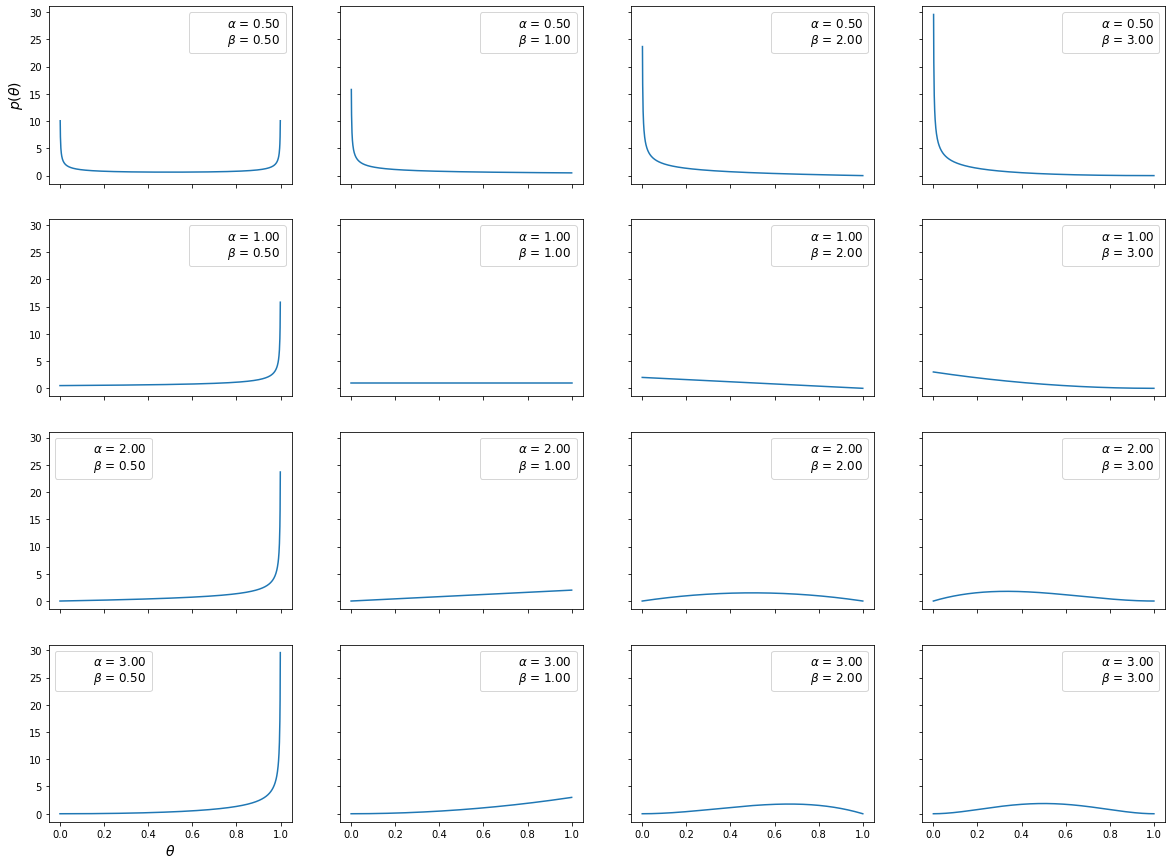

In [12]:
params = [0.5, 1, 2, 3]
x = np.linspace(0,1,1000)
f, ax = plt.subplots(len(params), len(params), sharex=True, sharey=True, figsize = (20,15))
for i in range(len(params)):
    for j in range(len(params)):
        a = params[i]
        b = params[j]
        y = stats.beta(a, b).pdf(x)
        ax[i,j].plot(x, y)
        ax[i,j].plot(0, 0, label= f"$\\alpha$ = {a:3.2f}\n$\\beta$ = {b:3.2f}", alpha=0)
        ax[i,j].legend(fontsize=12)
ax[3,0].set_xlabel('$\\theta$', fontsize=14)
ax[0,0].set_ylabel('$p(\\theta)$', fontsize=14)

Why use the beta function? Bc its the conjugate prior of the binomial distribution. A conjugate prior of a likelihood is a prior that, when used in combination with the given likelihood, returns a posterior with the same functional form as the prior. Lay mans terms, every time we use a beta distribution as
prior and a binomial distribution as likelihood, we will get a beta as a posterior.

## Now to the posterior:

Bayes theorem:
    
$p(\theta|y)\propto p(y|\theta)p(\theta)$

Because the beta function is the conjugate prior of the binomial distribution, the posterior will be the beta function:

$ p(\theta|y) =Beta(\theta_{prior} + y, \beta_{prior} + N -y) $

Compute the old way:

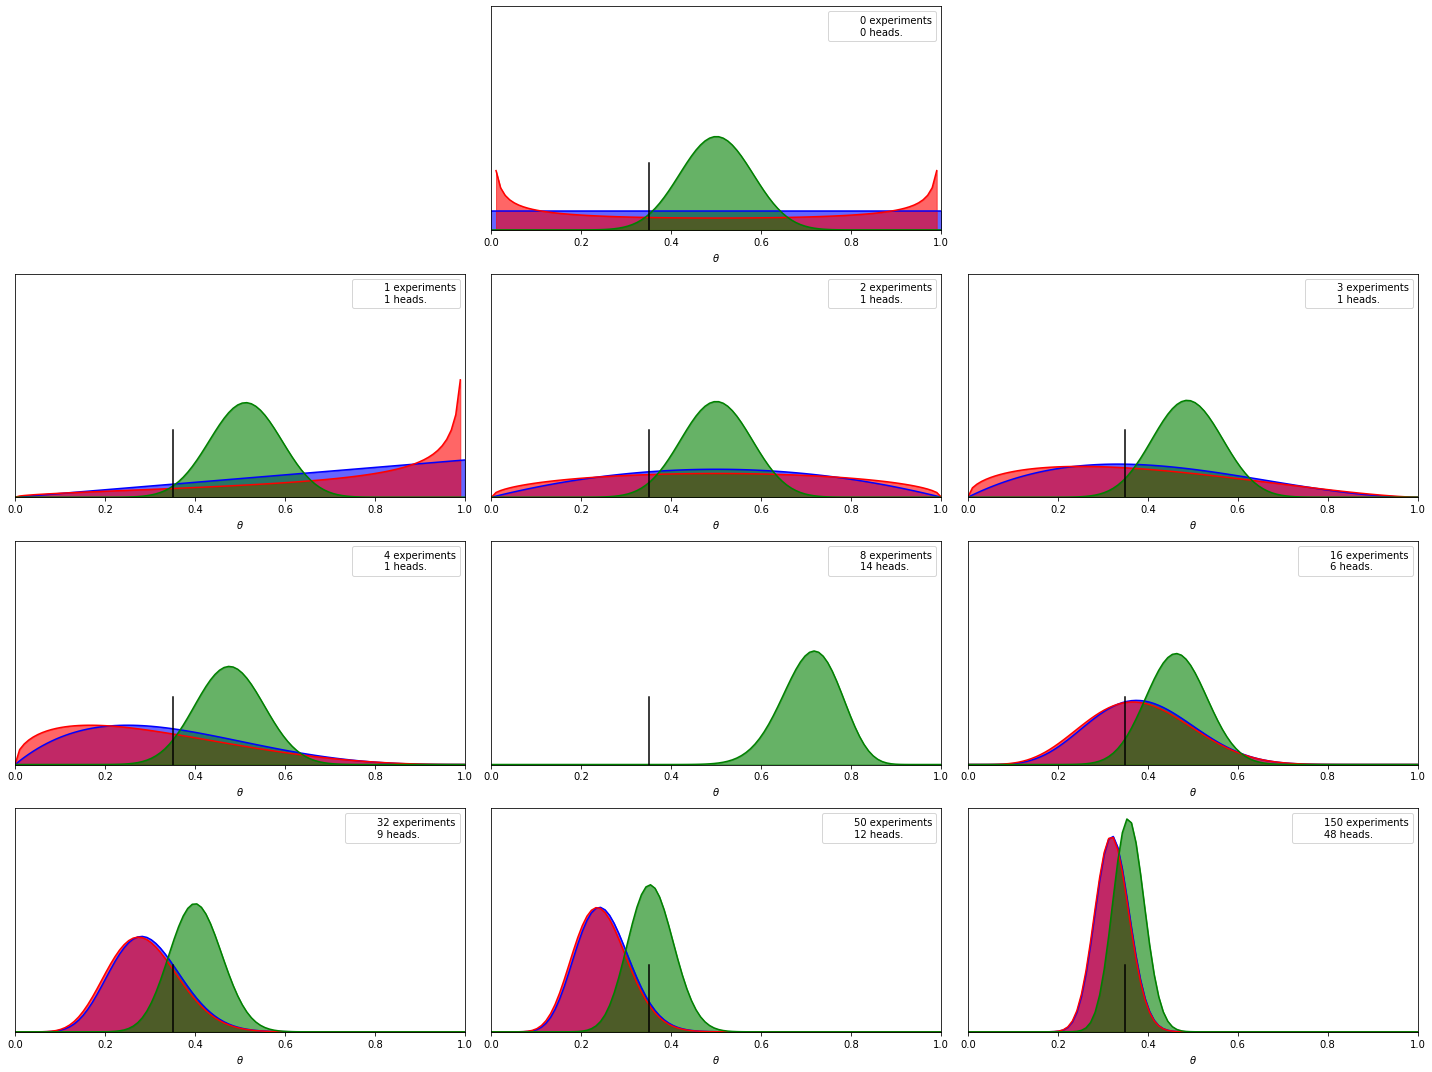

In [22]:
theta_real = 0.35
trials = [0,1,2,3,4,8,16,32,50,150]
data = [0,1,1,1,1,14,6,9,12,48]

beta_params = [(1,1), (0.5, 0.5), (20, 20)]
dist = stats.beta

x = np.linspace(0, 1, 100)
plt.figure(figsize=(20,15))
for idx, N in enumerate(trials):
    if idx == 0:
        plt.subplot(4,3,2)
    else:
        plt.subplot(4,3, idx+3)
    
    y = data[idx]
    for (a_prior, b_prior), c in zip(beta_params, ('b', 'r', 'g')):
        p_theta_given_y = dist.pdf(x, a_prior+y, b_prior+N-y)
        plt.plot(x, p_theta_given_y, c)
        plt.fill_between(x, 0, p_theta_given_y, color = c, alpha = 0.6)
        
    plt.axvline(theta_real, ymax=0.3, color='k')
    plt.plot(0,0, label=f"{N:d} experiments\n{y:d} heads.", alpha=0)
    plt.xlim(0,1)
    plt.ylim(0,12)
    plt.xlabel(r"$\theta$")
    plt.legend()
    plt.gca().axes.get_yaxis().set_visible(False)
plt.tight_layout()

Code run:

Initialization: 

* Blue is a uniform prior

* Red is close to uniform prior but weighted more at 0, or 1. 

* Green is centered around 0.5 "Belief is fair"

Results:
* Most probable given by mode

* Spread is uncertainty about the value

* Eventually all priors tend to converge on to the same results




## How to represent the analysis:

To represent the data and model:

* $\theta ~ Beta(\alpha, \beta)$

* $y ~ Beta(n=1, p=\theta)$

The results:

* Report mean median or mode

* For spread/uncertainty report the Highest Posterior Density (HPD) or credibility interval-> Similar to the CI

e.g. mode = 0.5  [0.25-0.75] 0.95 HPD. 

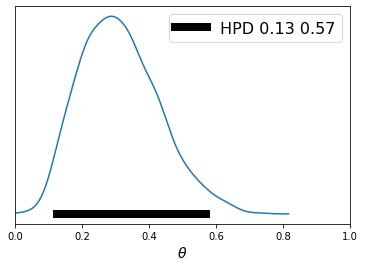

In [29]:
def naive_hpd(post):
    sns.kdeplot(post)
    HPD = np.percentile(post, [2.5, 97.5])
    plt.plot(HPD, [0, 0], label='HPD {:.2f} {:.2f}'.format(*HPD),
    linewidth=8, color='k')
    plt.legend(fontsize=16)
    plt.xlabel(r'$\theta$', fontsize=14)
    plt.gca().axes.get_yaxis().set_ticks([])
    
np.random.seed(1)
post = stats.beta.rvs(5, 11, size = 1000)
naive_hpd(post)
plt.xlim(0,1)
plt.show()

## Multimodal:

more complex

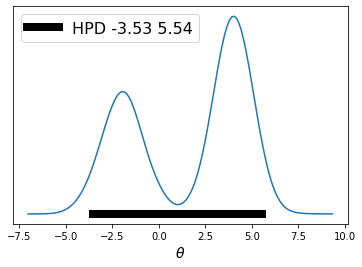

In [30]:
np.random.seed(1)
gauss_a = stats.norm.rvs(loc=4, scale=0.9, size=3000)
gauss_b = stats.norm.rvs(loc=-2, scale=1, size=2000)
mix_norm = np.concatenate((gauss_a, gauss_b))

naive_hpd(mix_norm)

Not correct. See this method:
https://github.com/aloctavodia/Doing_bayesian_data_analysis/blob/master/plot_post.py

## Non-Markovian Processes

#### Grid:

In [37]:
def posterior_grid(grid_points=100, heads=6, tosses=9):
    """
    Grid implementation of coin flip
    """
    grid = np.linspace(0,1, grid_points)
    prior = np.repeat(5, grid_points)
    likelihood = stats.binom.pmf(heads, tosses, grid)
    unstd_posterior = likelihood * prior
    posterior = unstd_posterior / unstd_posterior.sum()
    return grid, posterior

Assumption:

4 tosses

1 head

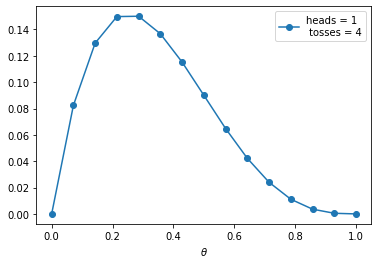

In [38]:
points = 15
heads, n_tosses = 1, 4
grid, posterior = posterior_grid(points, heads, n_tosses)
plt.plot(grid, posterior, "o-", label = f"heads = {heads}\n tosses = {n_tosses}")
plt.xlabel(r"$\theta$")
plt.legend(loc=0)


In [2]:
def metropolis(func, steps = 10000):
    """A basic metropolis implementation"""
    samples = np.zeros(steps)
    old_x = func.mean()
    old_prob = func.pdf(old_x)
    
    for i in range(steps):
        new_x = old_x + np.random.normal(0,0.5)
        new_prob = func.pdf(new_x)
        acceptance = new_prob/old_prob
        if acceptance >= np.random.random():
            samples[i] = new_x
            old_x = new_x
            old_prob = new_prob
        else:
            samples[i] = old_x
            
    return samples

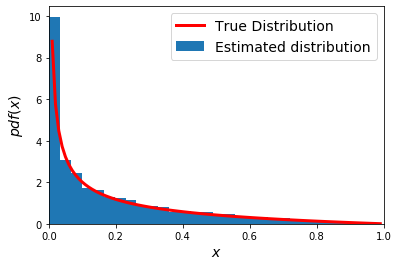

In [5]:
func = stats.beta(0.4, 2)
samples = metropolis(func=func)
x = np.linspace(0.01, 0.99, 100)
y = func.pdf(x)
plt.plot(x, y, 'r-', lw = 3, label = "True Distribution")
plt.hist(samples, bins = 30, density=True, label = "Estimated distribution")
plt.xlim(0,1)
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$pdf(x)$", fontsize=14)
plt.legend(fontsize=14)
plt.show()

## Intro to pymc3

In [2]:
import pymc3 as pm

In [3]:
np.random.seed(42)
n_experiments = 5
theta_real = 0.35
data = stats.bernoulli.rvs(p=theta_real, size = n_experiments)
data

array([0, 1, 1, 0, 0])

In [4]:
with pm.Model() as first_model:
    theta = pm.Beta("theta", alpha = 1, beta = 1)
    y = pm.Bernoulli("y", p = theta, observed = data)
    
state = pm.find_MAP(model=first_model)

logp = -3.4657, ||grad|| = 0.5: 100%|██████████| 6/6 [00:00<00:00, 226.78it/s]


In [5]:
with first_model:
    trace = pm.sample(10000, step=pm.Metropolis())

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [00:05<00:00, 7781.63draws/s]
The number of effective samples is smaller than 25% for some parameters.


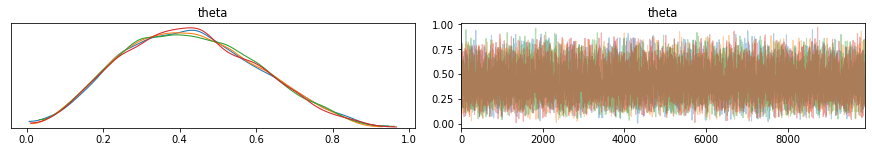

In [6]:
burnin = 100
chain = trace[burnin:]
pm.traceplot(chain, lines={"theta":theta_real})
plt.show()

In [7]:
pm.gelman_rubin(chain)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    theta    float64 1.0

In [8]:
with first_model:
    multi_trace = pm.sample(1000, step =pm.Metropolis(), chains=4)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:00<00:00, 6715.32draws/s]
The number of effective samples is smaller than 25% for some parameters.


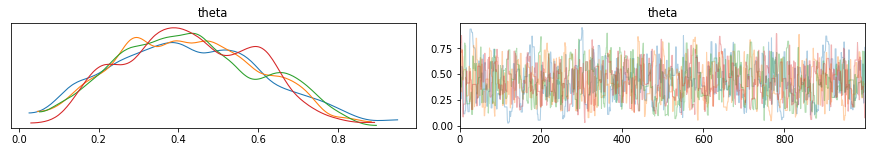

In [9]:
burnin = 0
multi_chain = multi_trace[burnin:]
pm.traceplot(multi_chain, lines={"theta":theta_real})
plt.show()

In [11]:
pm.gelman_rubin(multi_chain)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    theta    float64 1.002

In [12]:
multi_chain

<MultiTrace: 4 chains, 1000 iterations, 2 variables>

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f490fc6b550>],
      dtype=object)

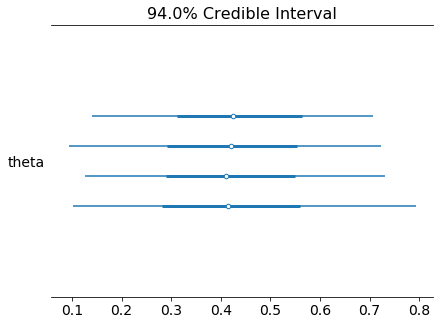

In [13]:
pm.forestplot(multi_chain, varnames=["theta"])

In [14]:
pm.summary(multi_chain)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta,0.429,0.178,0.129,0.764,0.006,0.004,800.0,800.0,770.0,805.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f490c8c6410>]],
      dtype=object)

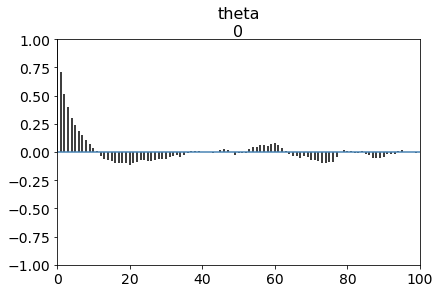

In [15]:
pm.autocorrplot(multi_chain)

In [19]:
with first_model:
    multi_trace10000 = pm.sample(10000, step =pm.Metropolis(), chains=4)
    multi_trace50000 = pm.sample(50000, step = pm.Metropolis(), chains = 4)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [00:05<00:00, 8352.53draws/s]
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]
Sampling 4 chains, 0 divergences: 100%|██████████| 202000/202000 [00:29<00:00, 6933.41draws/s]
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4910105f50>]],
      dtype=object)

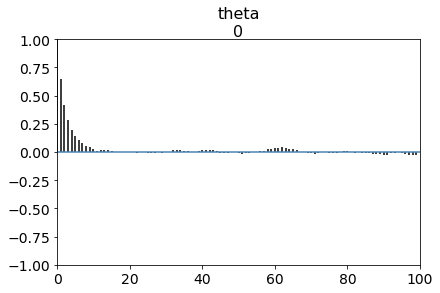

In [18]:
pm.autocorrplot(multi_trace10000)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f490dc9f690>]],
      dtype=object)

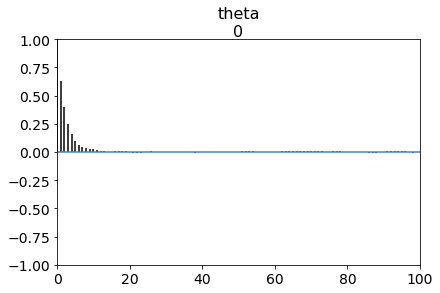

In [21]:
pm.autocorrplot(multi_trace50000[1000:])

In [23]:
pm.effective_n(multi_chain)["theta"]

<xarray.DataArray 'theta' ()>
array(769.62129624)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f490fc9bc50>],
      dtype=object)

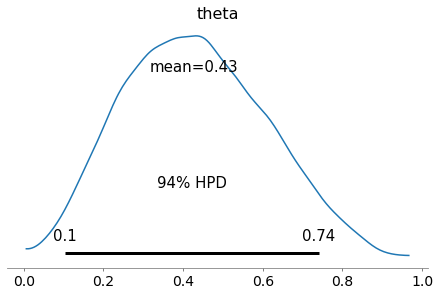

In [25]:
pm.plot_posterior(chain)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f49104a3090>],
      dtype=object)

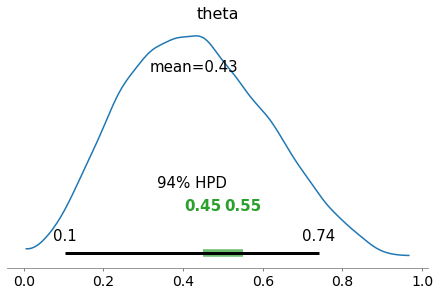

In [27]:
pm.plot_posterior(chain,rope=[0.45, .55])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f490eeb6a50>],
      dtype=object)

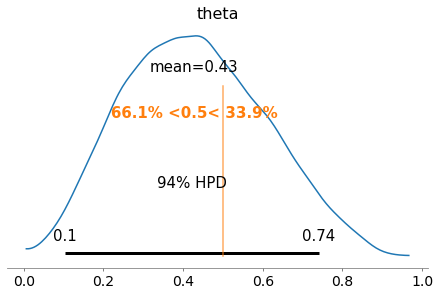

In [29]:
pm.plot_posterior(chain, ref_val=0.5)

66% of posterior is below 0.5 and 33.9% is above

### Chapter 2:

##### Exercises:

In [35]:
def posterior_grid_exp1(grid_points=100, heads=6, tosses=9):
    """
    Grid implementation of coin flip
    """
    grid = np.linspace(0,1, grid_points)
    prior = np.repeat(5, grid_points)
    likelihood = stats.binom.pmf(heads, tosses, grid)
    unstd_posterior = likelihood * prior
    posterior = unstd_posterior / unstd_posterior.sum()
    return grid, posterior

In [1]:
 def posterior_grid_exp2(grid_points=100, heads=6, tosses=9):
    """
    Grid implementation of coin flip
    """
    grid = np.linspace(0,1, grid_points)
    prior = (grid_points <=0.5).astype(int)
    print(prior)
    likelihood = stats.binom.pmf(heads, tosses, grid)
    unstd_posterior = likelihood * prior
    posterior = unstd_posterior / unstd_posterior.sum()
    return grid, posterior

In [2]:
 def posterior_grid_exp3(grid_points=100, heads=6, tosses=9):
    """
    Grid implementation of coin flip
    """
    grid = np.linspace(0,1, grid_points)
    prior = abs(grid-0.5)
    print(prior)
    likelihood = stats.binom.pmf(heads, tosses, grid)
    unstd_posterior = likelihood * prior
    posterior = unstd_posterior / unstd_posterior.sum()
    return grid, posterior

In [3]:
points = 15
heads, n_tosses = 1, 4
grid, posterior = posterior_grid_exp1(points, heads, n_tosses)
plt.plot(grid, posterior, "o-", label = f"heads = {heads}\n tosses = {n_tosses}")
plt.xlabel(r"$\theta$")
plt.legend(loc=0)


NameError: name 'posterior_grid_exp1' is not defined

[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]


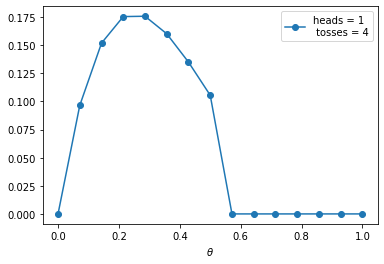

In [47]:
points = 15
heads, n_tosses = 1, 4
grid, posterior = posterior_grid_exp2(points, heads, n_tosses)
plt.plot(grid, posterior, "o-", label = f"heads = {heads}\n tosses = {n_tosses}")
plt.xlabel(r"$\theta$")
plt.legend(loc=0)

[0.5        0.42857143 0.35714286 0.28571429 0.21428571 0.14285714
 0.07142857 0.         0.07142857 0.14285714 0.21428571 0.28571429
 0.35714286 0.42857143 0.5       ]


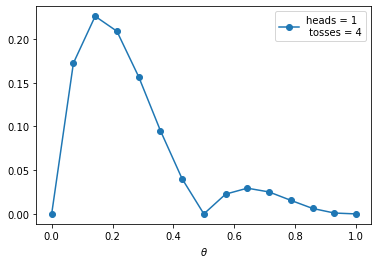

In [48]:
points = 15
heads, n_tosses = 1, 4
grid, posterior = posterior_grid_exp3(points, heads, n_tosses)
plt.plot(grid, posterior, "o-", label = f"heads = {heads}\n tosses = {n_tosses}")
plt.xlabel(r"$\theta$")
plt.legend(loc=0)